**Game of Thrones data analysis** <br>
[data](https://www.kaggle.com/mylesoneill/game-of-thrones#battles.csv)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import numpy as np
import plotly

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
# import data
battles = pd.read_csv("data/battles.csv")
deaths  = pd.read_csv("data/character-deaths.csv")
deaths = deaths.dropna()

battles['attacker_outcome']
# deaths.head()

0      win
1      win
2      win
3     loss
4      win
5      win
6      win
7      win
8      win
9      win
10     win
11     win
12     win
13     win
14     win
15     win
16    loss
17     win
18     win
19    loss
20     win
21    loss
22     win
23     win
24     win
25     win
26     win
27    loss
28     win
29     win
30     win
31     win
32     win
33     win
34     win
35     win
36     win
37     NaN
Name: attacker_outcome, dtype: object

In [8]:
# http://hauteslides.com/2011/05/game-of-thrones-infographic-illustrated-guide-to-houses-and-character-relationships/
house_colors = {'Lannister':'yellow',
                'Stark':'gray',
                'Greyjoy':'purple',
                'Bolton':'white',
                'Baratheon':'brown',
                'Darry':'maroon',
                'Brotherhood without Banners':'blue',
                'Frey':'lightgray',
                'Free folk':'orange',
                'Brave Companions':'aliceblue',
                'Bracken':'lightpink',
                'Blackwood':'k',
                "Night's Watch": 'midnightblue',
                'Mallister': 'indigo',
                'Tyrell': 'limegreen',
                'Tully': 'firebrick'}

Results of one-way ANOVA:
                        df  sum_sq     mean_sq        F    PR(>F)
deaths_per_book.index  1.0   136.9  136.900000  0.16955  0.708164
Residual               3.0  2422.3  807.433333      NaN       NaN

p-value: 0.708
r-value: -0.23

Conclusion: No significant correlation! - GoT has not become more violent over time.


/home/jan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/home/jan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/home/jan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning:

invalid value encountered in less_equal



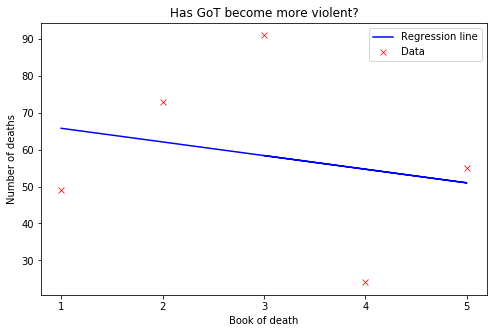

In [9]:
deaths_per_book = deaths["Book of Death"].value_counts(sort=False)  # count number of deaths per book

model = ols('deaths_per_book ~ deaths_per_book.index', data=deaths_per_book).fit()  # least-squares model
results = sm.stats.anova_lm(model, type=1)  # one-way ANOVA
print('Results of one-way ANOVA:')
print(results)
print()

# use different package in order to plot the regression line 
slope, intercept, r, p, std = stats.linregress(deaths_per_book.index, deaths_per_book)
print('p-value: {:.3f}'.format(p))
print('r-value: {:.2f}'.format(r))

print()
print('Conclusion: No significant correlation! - GoT has not become more violent over time.')

# plot results
fig, axes = plt.subplots(figsize=(8,5))
sns.scatterplot(x=deaths_per_book.index, y=deaths_per_book, color='r', marker='x', ax=axes)
axes.set(xticks=[1,2,3,4,5], xlabel='Book of death', ylabel='Number of deaths', title='Has GoT become more violent?')
axes.plot(deaths_per_book.index, intercept + slope*deaths_per_book.index, color='b')
axes.legend(['Regression line', 'Data'])
plt.show()

In [10]:
# Clean the data
battles = battles[battles['attacker_outcome'].notna()]

# Build new dataframe to count the battles
battle_counts = battles.groupby(['attacker_1', 'attacker_outcome', 'battle_type', 'defender_1']).size().reset_index(name='counts')

attacker_names = battle_counts['attacker_1'].unique()
defender_names = battle_counts['defender_1'].unique()
attacker_colors = [house_colors[name] for name in attacker_names]
defender_colors = [house_colors[name] for name in defender_names]

# Set new columns in dataframe
battle_counts['attacker_1_cat'] = battle_counts['attacker_1'].astype('category').cat.codes
battle_counts['defender_1_cat'] = battle_counts['defender_1'].astype('category').cat.codes + battle_counts['attacker_1_cat'].max() + 1
battle_counts['attacker_color'] = battle_counts['attacker_1'].map(house_colors)
battle_counts['defender_color'] = battle_counts['defender_1'].map(house_colors)
battle_counts['attacker_outcome_cat'] = battle_counts['attacker_outcome'].astype('category').cat.codes + battle_counts['defender_1_cat'].max() + 1

# Set plot variables
## Nodes
labels = list(attacker_names) + list(defender_names) + ['loss', 'win']
colors = attacker_colors + defender_colors + ['orangered', 'seagreen']

## Links
sources = list(battle_counts['attacker_1_cat']) + list(battle_counts['attacker_outcome_cat'])
targets = list(battle_counts['attacker_outcome_cat']) + list(battle_counts['defender_1_cat'])
values = list(battle_counts['counts']) + list(battle_counts['counts'])


# Set variables for the plot
data = dict(
    type='sankey',
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(
        color = "black",
        width = 0.5
      ),
      label = labels,
      color = colors
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values
  ))

layout =  dict(
    title = "Game of Thrones - House of Attacker vs. Outcome vs. House of Defender",
    font = dict(
      size = 10
    )
)

# Draw the plot
plotly.offline.init_notebook_mode(connected=True)
fig = dict(data=[data], layout=layout)
plotly.offline.iplot(fig, validate=False)